# Figure 17, Plot of overall Froude number vs dimensionless amplitude

Start by loading some boiler plate: matplotlib, numpy, scipy, json, functools, and a convenience class.

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import UnivariateSpline
import json
import pandas as pd
from functools import partial
class Foo: pass

And some more specialized dependencies:
 1. ``Slict`` provides a convenient slice-able dictionary interface
 2. ``Chest`` is an out-of-core dictionary that we'll hook directly to a globus remote using...
 3. ``glopen`` is an open-like context manager for remote globus files

In [2]:
from chest import Chest
from slict import CachedSlict
from glopen import glopen, glopen_many

Helper routines

In [3]:
def load_from_archive(names, arch):
    cs = []
    for name in names:
        cs.append(Chest(path      = "{:s}-results".format(name),
                        open      = partial(glopen,      endpoint=arch),
                        open_many = partial(glopen_many, endpoint=arch)))
    scs = [CachedSlict(c) for c in cs]

    ps = []
    for name in names:
        with glopen(
                    "{:s}.json".format(name), mode='r',
                    endpoint = arch,
                    ) as f:
            ps.append(json.load(f))
    if len(names) == 1:
        return cs[0], scs[0], ps[0]
    return cs, scs, ps

Configuration for this figure.

In [4]:
config = Foo()
config.names = [
    "Wilk/Wilk_long/Wilk_long",
#    "Wilk/Wilk_per/Wilk_per",
]
config.ref = ["Wilk/Wilk_per/Wilk_per",]
#config.arch_end = "maxhutch#alpha-admin/~/pub/"
#config.arch_end = "alcf#dtn_mira/projects/alpha-nek/experiments/"
config.arch_end = "alcf#dtn_mira/projects/PetaCESAR/maxhutch/"

Open a chest located on a remote globus endpoint and load a remote json configuration file.

In [5]:
c, sc, p = load_from_archive(config.names, config.arch_end);
rc, rsc, rp = load_from_archive(config.ref, config.arch_end);

We want to plot the spike depth, which is the 'H' field in the chest.
Chests can prefetch lists of keys more quickly than individual ones, so we'll prefetch the keys we want.

In [6]:
c.prefetch(sc[:,'H_exp'].full_keys())
c.prefetch(sc[:,'H_exp_cell'].full_keys())
rc.prefetch(rsc[:,'H_exp'].full_keys())
rc.prefetch(rsc[:,'H_exp_cell'].full_keys())

Use a spline to compute the derivative of 'H' vs time: the Froude number.

In [7]:
spls = []
Hs = []
Ts = []

rT = np.array(rsc[:,'H_exp'].keys())
rH = np.array([x for x in rsc[:,'H_exp'].values()])/4
rspl = UnivariateSpline(rT, rH, k = 5, s = 1.e-10)
rFr = rspl.derivative()

T = np.array(sc[:,'H_exp'].keys())
H = np.array([x for x in sc[:,'H_exp'].values()])
spls.append(UnivariateSpline(T, H, k = 5, s = 1.e-10))
Hs.append(H)
Ts.append(T)
    
nbubble = np.rint(p["kmin"]+.5).astype('int')
    
for i in range(10):
    T = np.array(sc[:,'H_exp'].keys())
    H = np.array([x[i] for x in sc[:,'H_exp_cell'].values()])
    spls.append(UnivariateSpline(T,
                                 H,
                                 k = 5,
                                 s = 1.e-10))
    Hs.append(H)
    Ts.append(T)
        
    
Frs = [spl.derivative() for spl in spls]    
T = np.linspace(sc[:,'H_exp'].keys()[0], sc[:,'H_exp'].keys()[-1], 1000)

Plot the Froude number, non-dimensionalized by the theoretical dependence on Atwood, acceleration, and wave number, vs the spike depth, normalized by wave-length.

The dotted line is the theoretical prediction of Goncharaov.  The solid black line is the farthest that Wilkinson and Jacobs were able to get.

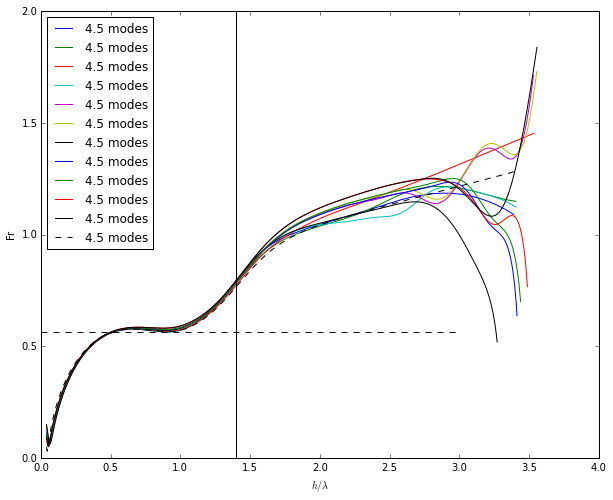

In [8]:
fig, axs = plt.subplots(1,1)
for spl, Fr in zip(spls[1:], Frs[1:]):
    axs.plot(
        spl(T)* p["kmin"] , 
        Fr(T)/ np.sqrt(p["atwood"]*p["g"] / p["kmin"]),
        label="{:3.1f} modes".format(p["kmin"]));

axs.plot(
    spls[0](T)* p["kmin"], 
    Frs[0](T) / np.sqrt(p["atwood"]*p["g"] / p["kmin"]),
    'k-', label="{:3.1f} modes".format(p["kmin"]) );
axs.plot(
    rspl(T)* rp["kmin"], 
    rFr(T) / np.sqrt(rp["atwood"]*rp["g"] / rp["kmin"]),
    'k--', label="{:3.1f} modes".format(rp["kmin"]) );

#axs.plot(Run37["AvgAmp (mm)"] * 2.5 / 76, Run37["Froude Average"], "bx");
#axs.plot(Run58["AvgAmp (mm)"] * 4.5 / 76, Run58["Froude Average"], "rx");
#axs.plot(Run78["AvgAmp (mm)"] * 3.5 / 76, Run78["Froude Average"], "gx");
axs.plot([0,3], [np.sqrt(1/np.pi), np.sqrt(1/np.pi)], 'k--')
axs.axvline(x=1.4, color='k');
axs.set_ylabel(r'Fr')
axs.set_xlabel(r'$h/\lambda$');
axs.legend(loc=0);
#axs.set_xbound(0,3.5)
#axs.set_ybound(0,1.5)
plt.savefig('Figure17.eps')

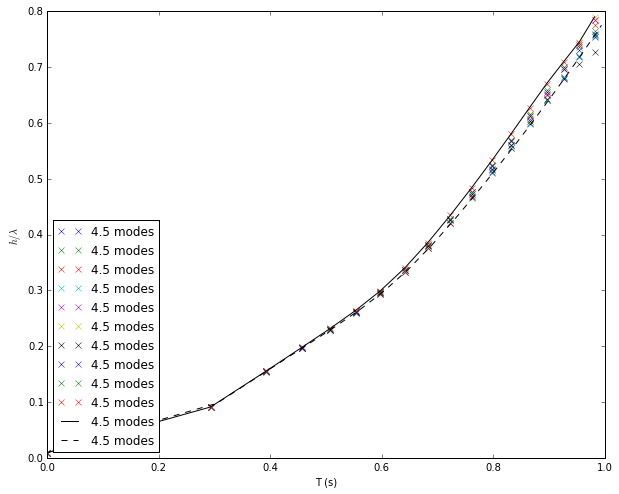

In [9]:
fig, axs = plt.subplots(1,1)

for H, T in zip(Hs[1:], Ts[1:]):
    axs.plot(
        T,
        H, 'x', 
        label="{:3.1f} modes".format(p["kmin"]));
axs.plot(
        Ts[0],
        Hs[0], 'k-', 
        label="{:3.1f} modes".format(p["kmin"]));
axs.plot(
        rT,
        rH, 'k--', 
        label="{:3.1f} modes".format(p["kmin"]));
#axs.plot(Run37["Time (sec)"]-.5, Run37["AvgAmp (mm)"] * 2.5 / 76, "bx");
#axs.plot(Run58["Time (sec)"]-.5, Run58["AvgAmp (mm)"] * 4.5 / 78, "rx");
#axs.plot(Run78["Time (sec)"]-.5, Run78["AvgAmp (mm)"] * 3.5 / 76, "gx");
axs.set_ylabel(r'$h/\lambda$')
axs.set_xlabel(r'T (s)');
axs.legend(loc=3);

In [10]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py 
%load_ext version_information 
%version_information numpy, matplotlib, slict, chest, glopen, globussh

Installed version_information.py. To use it, type:
  %load_ext version_information


Software versions
Python 3.4.3 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 3.2.0
OS Linux 3.16.0 4 amd64 x86_64 with debian 8.1
numpy 1.10.0.dev0+00f4fae
matplotlib 1.4.3
slict 0.2.5
chest 0.2.2
glopen 0.0.12
globussh 0.1.1
Tue Aug 11 10:53:39 2015 CDT